In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.api as sm

plt.style.use("classic")
%matplotlib inline

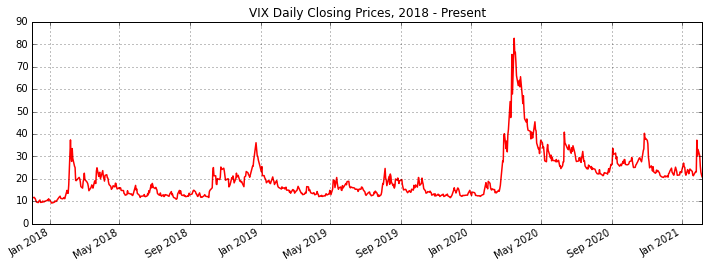

In [2]:
# load data directly from CBOE and do some preprocessing
df = pd.read_csv("https://ww2.cboe.com/publish/scheduledtask/mktdata/datahouse/vixcurrent.csv", skiprows = 1, header = 0, 
                names = ["date", "open", "high", "low", "close"], index_col = ["date"], parse_dates = True)

# plot the raw close data for presentation purposes
df.close.tail(800).plot(x_compat = True, figsize = (12, 4), grid = True,
              title = "VIX Daily Closing Prices, 2018 - Present", 
              xlabel = "", lw = 1.5, color = "r")

plt.show()

The VIX index measures the expected market volatility over the next 30 days based on S&P 500 index options. The S%P 500 is known for representing the overall health of the U.S. economy, making VIX a notable indicator for measuring "fear" in the market. Specifically, VIX and the S&P 500 are inverses of each other, as an increase in VIX implies that market participants are becoming uneasy about the future of the economy. 

This can be verified from the prices alone. From the chart above, the sharp spike in prices between March 2020 and April 2020 correlates to the time when the COVID-19 pandemic becaome recognized in the U.S. Intuitively, this spike implies fear and uncertainty among market participants, which can be reasoned by the lack of preparation for the pandemic. 

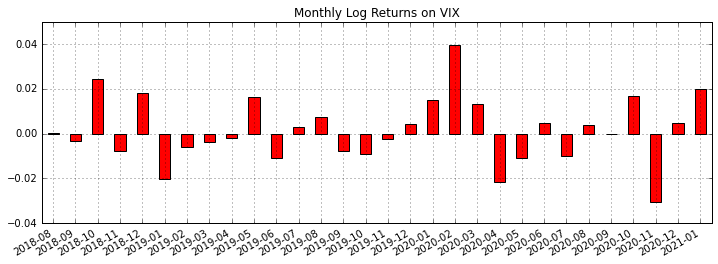

In [3]:
# calculate the log returns from closing prices
df_returns = np.log(df.close).diff().dropna()

# resample by month and aggregate by mean
df_returns = df_returns.resample("M").mean()

# reformat index from datetime
df_returns.index = df_returns.index.strftime("%Y-%m")

# plot the last 30 months (but ignore the last bar, which is Feb. 2021)
df_returns[:-1].tail(30).plot.bar(grid = True, ylim = (-.04, .05), figsize = (12, 4),
                            title = "Monthly Log Returns on VIX", xlabel = "", color = "r")
# rotate the xticks
plt.gcf().autofmt_xdate()
plt.show()

The bar chart above shows the monthly log returns on VIX.

The bars following the spike from the pandemic are interesting, as they indicate that markets may be strengthening since there are sharp downticks and short upticks. However, this assumes that the pandemic suddenly didn't exist, which is not the case at all. 

In [4]:
# calculate the log returns from closing prices
df_returns = np.log(df.close).diff().dropna()
returns = df_returns.to_numpy()

# create time lags (in days)
# 1260 = 252 (business days) * 5 (years) 
lags = np.arange(1, 1260)     

# placeholder results
beta = []
rsquared = []

for i in lags:                                # For every time lag "i"...
    y = []                                  
    x = []
    for t in range(i, len(returns)-i):        # iterate through a time window fitted to "i" 
        t_past =  returns[t-i:t]              # get the return of the past "t" periods
        t_fut  =  returns[t:t+i]              # get the return of "t" periods into the future
        y.append(np.sum(t_fut))               # summate the returns within the window
        x.append(np.sum(t_past))              # "                                   "
    model = sm.OLS(y, x, hasconst = False)    # use a simple OLS model to fit the relationship between past and future returns
    results = model.fit()   
    beta.append(results.params[0])            # store betas
    rsquared.append(results.rsquared)         # store rsquared

# the next section will plot, as this takes time to run

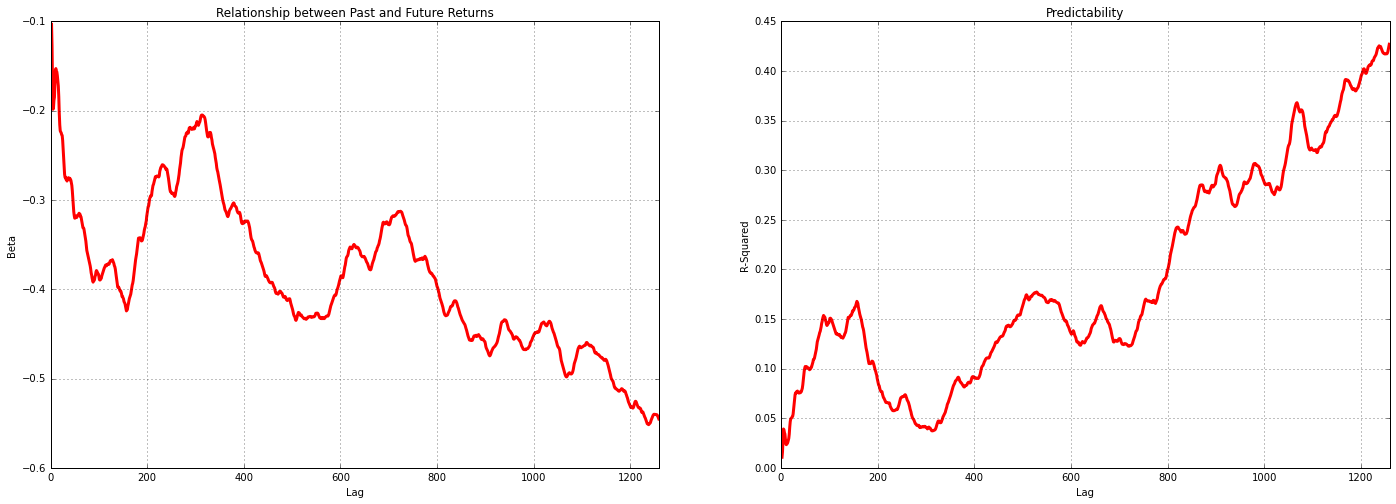

In [5]:
# create a plot suitable for 2 charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (24, 8))

# plot betas
ax1.plot(lags, beta, lw = 3, color = "r")
ax1.set_xlim(0, 1260)
ax1.set_title("Relationship between Past and Future Returns")
ax1.set_xlabel("Lag")
ax1.set_ylabel("Beta")
ax1.grid()

# plot r-squared
ax2.plot(lags, rsquared, lw = 3, color = "r")
ax2.set_xlim(0, 1260)
ax2.set_title("Predictability")
ax2.set_xlabel("Lag")
ax2.set_ylabel("R-Squared")
ax2.grid()

plt.show()

The cells above simulate and visualize the predictability of VIX at different time lags.

Specifically, for every time lag, create a rolling window and summate the returns above and below the window. The returns above the window represent future returns and the returns below represent past returns. An OLS model fits the relationship between the two s.t. 

### $$y_{t+1,t+i} = \beta_{i} * y_{t-i,t} + w_{t,i}$$

where at time lag $i$, $y_{t+1,t+i}$ and $y_{t-i,t}$ represent the future and past logarithmic returns, $\beta_{i}$ represents the relationship between the two, and $w_{t,i}$ is white noise. 

The leftmost chart shows the relationship between the returns. Notably, there is a strong yearly cyclical pattern (~252 days). The rightmost chart displays the R-Squared values, which can be interpreted as the predictability between past and future returns. The strong upward trend and uncertainty compliments the previous results and perhaps validates the cyclical nature of the economy. 

From this alone, mean-reversion at 2 year (~500) and 4 year (~1000) lags could indicate where the economy is headed. 

The contents below are just some extra graphs I did while exploring stationary processes and using the statsmodels library. 

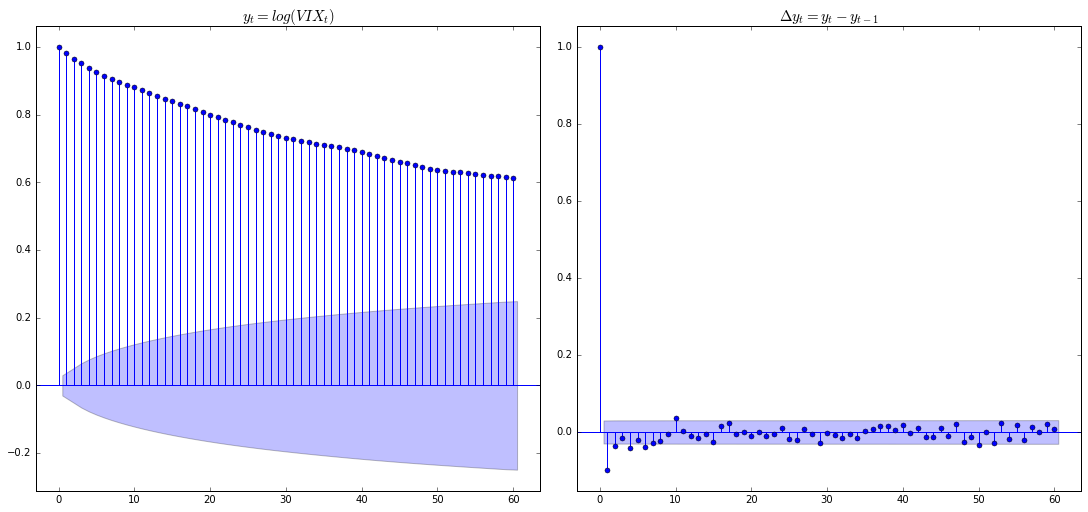

In [8]:
df_log = np.log(df.close).dropna()                # Log Prices
df_log_delta = np.log(df.close).diff().dropna()   # Log Returns (first difference)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 7), constrained_layout = True)

# Perform a Auto-Correlation Function (ACF) test 

# Plot prices with lag 60
sm.graphics.tsa.plot_acf(df_log, ax1, lags = 60)
ax1.set_title(r"$y_t = log(VIX_t)$", fontsize = 15)

# Plot returns with lag 60
sm.graphics.tsa.plot_acf(df_log_delta, ax2, lags = 60)
ax2.set_title(r"$\Delta y_t = y_t - y_{t-1}$", fontsize = 15)

plt.show()